<font size="5">Galaxy JO204</font>

We will first be reading the [FITS](https://heasarc.gsfc.nasa.gov/docs/heasarc/fits_overview.html) file containing the results/measures obtained for this galaxy, from IFS observations. 

In [70]:
#import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy as sc
import statistics
import matplotlib.patches as mpatches



# Data for JO204

hdu = fits.open('red_jo204_3D_SLres_VBIN015_total.fits.gz', memmap=True)  
# .gz means that the file is compressed
# but since, even compressed, the file is big, we opened it with memmap=True to prevent RAM storage issues.

# HDU stands for Header Data Unit. A fits file is a collection of HDUs (at least there is one, the primary HDU, but there can be more - this depends on the data).
# An HDU is composed of a header and data.


In [71]:
# In the case of our fits file, let's check how many HDUs there are:

nHDUs = np.size(hdu[:])
print("Number of HDUs: {}".format(nHDUs))

Number of HDUs: 1


In [72]:
# Let's check some general information on the file:

hdu.info()

Filename: red_jo204_3D_SLres_VBIN015_total.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   (353, 370, 72)   float32   


In [73]:
# There's indeed just one HDU, the primary one.
# But we see that the file has 3 dimensions/axis, so it's actually a datacube. The first 2 dimensions are spatial: (x,y).
# The third dimension contains layers of data: quantities measured and stored for each pixel (x,y).

# Let's check the header of this single HDU, to understand what the layers are:

hdu[0].header  # displays the header of the fits file

SIMPLE  =                    T / Standard FITS format: NOST 100-2.0             
BITPIX  =                  -32 / No. of bits per pixel                          
NAXIS   =                    3 / No. of axes in image                           
NAXIS1  =                  353 / No. of pixels                                  
NAXIS2  =                  370 / No. of pixels                                  
NAXIS3  =                   72 / No. of pixels                                  
EXTEND  =                    T / FITS extension may be present                  
COMMENT NOST 100-2.0: Hanisch,R. et al. 2001, Astron. & Astrophys. 376, 559     
                                                                                
                                                                                
CRPIX1  =                   1. / Reference pixel                                
CRVAL1  =                   1. / Coordinate at reference pixel                  
CDELT1  =                   

The header provides the information of the several layers (L) in the file: there are 72 and the list identifies them.

<!-- [JO204_vstellar.png](attachment:121417c3-ae4c-4b8d-85ef-720bf4ad9acf.png) -->
We can start by plotting two simple maps that show the kinematics of the stars: the map of stellar velocities and the map of the velocity dispersion of the stars. We can next compare with the velocity of the gas.

In the first case, you should be able to reproduce something like the following image:

<div>
<img src="JO204_vstellar.png" width="500"/>
</div>

For the gas, you should obtain:

<div>
<img src="JO204_vgas.png" width="500"/>
</div>

Before proceeding, and from the above maps: can you see a pattern? What does it mean?

This means we have (layers, y, x), indicated in this order.

In [74]:
# Let's start by simplifying and extracting the data for an array:

data = hdu[0].data

hdu.close() # Close the FITS file - you already read it and stored it in array "data" so you don't need it anymore! In this way, you're sure it won't continue using up excess memory or file handles on your computer. (This happens automatically when you close Python, but you never know how long that might be...)

# First let's check the shape of the array:

print(data.shape)


(72, 370, 353)


In [75]:
vel = data[6,:,:]
sigma_vel = data[7,:,:]

print(vel.shape) # to make sure
print(sigma_vel.shape)

y, x = vel.data.shape   # note the order: y, x!! That is, number of pixel rows first, number of pixel columns second.
print(x,y)

(370, 353)
(370, 353)
353 370


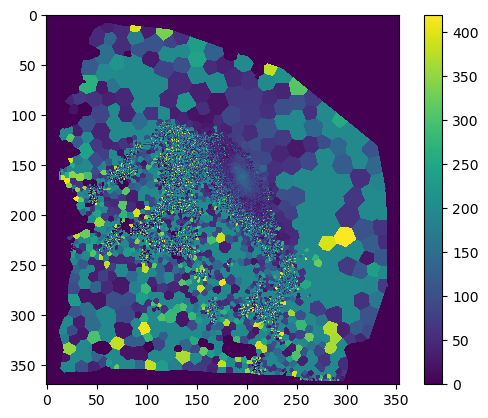

In [76]:
# making a map of the velocity:

fig, ax = plt.subplots()
im = ax.imshow(vel)
plt.colorbar(im);
plt.show()

You can see that the origin of the numbering of the pixels is on the upper left - which, for images, is a bit counter-intuitive...

Also, there are a lot of [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) that you can choose from. We can try a [logarithmic color scale](https://matplotlib.org/stable/tutorials/colors/colormapnorms.html) instead.

Defining more parameters of the ax.imshow python module allows us to address these two issues:

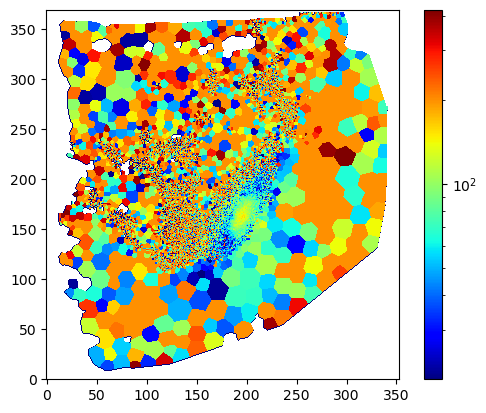

In [77]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
im = ax.imshow(vel, origin="lower", cmap=plt.get_cmap("jet"),norm=colors.LogNorm(),)
plt.colorbar(im);
plt.show()

The orientation of the axis is fine now, but we can do much better: improve the contrast - let's try using astropy.visualization.

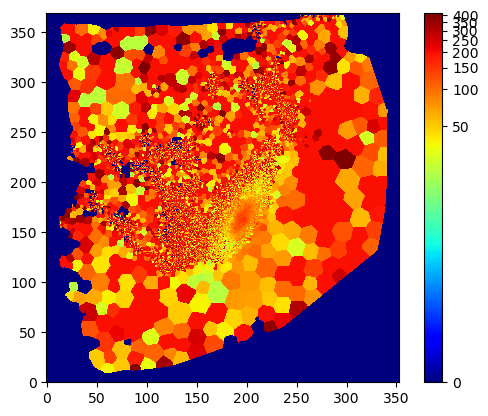

In [78]:
from astropy.visualization import simple_norm
norm = simple_norm(vel, 'log')
im = plt.imshow(vel, origin='lower', norm=norm, cmap=plt.get_cmap("jet"))
plt.colorbar(im);
plt.show()  

We need to limit the range of the display intensity to values close to the limits of the image intensity - here, it took the borders that actually don't contain data.

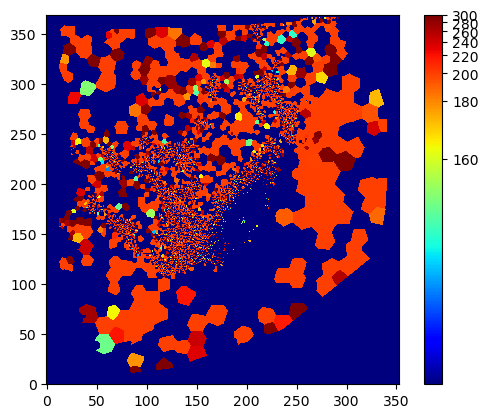

In [79]:
from astropy.visualization import ZScaleInterval
#zscale = ZScaleInterval()
#zlims = zscale.get_limits(vel)
#print(zlims) # just to check
norm = simple_norm(vel, 'log', min_cut=150, max_cut=300)
im = plt.imshow(vel, origin='lower', norm=norm, cmap=plt.get_cmap("jet"))
plt.colorbar(im);
plt.show()

And with this, we see that using a logarithmic scale may not be necessary, so in case we want to get rid of that, we just use:

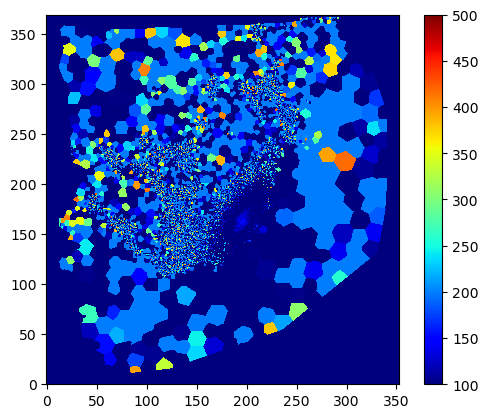

In [80]:
norm = simple_norm(vel, min_cut=100, max_cut=500)
im = plt.imshow(vel, origin='lower', norm=norm, cmap=plt.get_cmap("jet"))
plt.colorbar(im);
plt.show() 

Exercises:

1. Improve the map above by:
        
- changing the axis to arcsecs (the central pixel is (0,0), the pixel scale should be ~0.2 arcsec/pix (see the MUSE website and the header of the fits file).

- labeling the axis and the colorbar

- drawing contours on top of the colormap

- obtaining something more similar (in color display) to the image shown

2. Make more maps with the available quantities - suggestion: start with the H$\alpha$ emission map).


In [81]:
# Functions I'm going to use 

# turning arcsec to kiloparsec
def arcsec2pc(θ):
    d = 192.92*10**3 # (kpc)
    s = d * θ * np.pi/(180*60*60)
    return s # (kpc)
def pc2arcsec(θ):
    d = 192.92*10**3 # (kpc)
    s2 = d * θ / np.pi*(180*60*60)
    return s2 

print("1 arcsec = {} kpc".format( arcsec2pc(1) ))
print("20 arcsec = {} kpc".format( arcsec2pc(20) ))
print(arcsec2pc(49.5))


def masking(array2D, a, b):   # Domain [a,b]
    array2DMask = array2D.copy()
    for i in range( len(array2D[:,0]) ):
        for j in range( len(array2D[0,:]) ):
            #remove noise
            if array2D[i,j] < a or array2D[i,j] > b:
                array2DMask[i,j] = 0
    return array2DMask

def masking2(array2D, a, b):   # Domain [a,b]
    array2DMask = array2D.copy()
    for i in range( len(array2D[:,0]) ):
        for j in range( len(array2D[0,:]) ):
            if array2D[i,j] < a :
                array2DMask[i,j] = a
            elif array2D[i,j] > b:
                array2DMask[i,j] = b
    return array2DMask

def maskAbs(A): # A is a 2d array
    B = A.copy()
    for i in range( len(A[:,0]) ):
        for j in range( len(A[0,:]) ):
            B[i,j] = abs(A[i,j])
    return B

# turning nº of points into arcsec
x0 = -32.8
xf = data.shape[2]*0.2 - 32.8
y0 = -data.shape[1]*0.2 + 39.2
yf = 39.2
print("(layers, y, x) = {}".format(data.shape))

1 arcsec = 0.9353025535965169 kpc
20 arcsec = 18.706051071930336 kpc
46.29747640302758
(layers, y, x) = (72, 370, 353)


Aviso: x , y são arrays com o mesmo comprimento


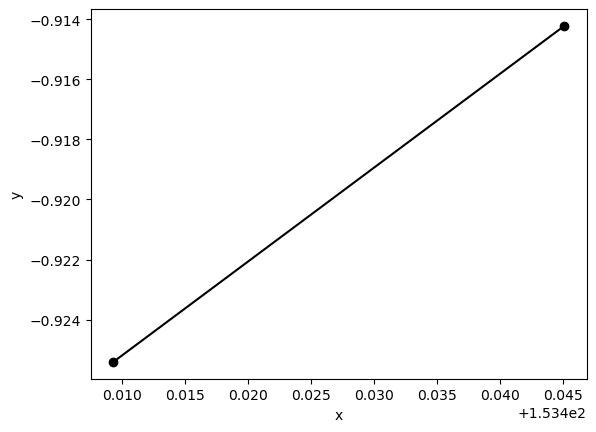

y = m * x + b    ou    x = (y-b) / m
m = 0.31257508570103737
b = -48.87733197139442


In [82]:
# Definig the arrow
def AjusteLinear(x,y): #método mínimos quadrados
    print("Aviso: x , y são arrays com o mesmo comprimento")
    N = len(x)

    Ex = 1/N * sum(x)
    Ey = 1/N * sum(y)
    Exx = 1/N * sum(x**2)
    Exy = 1/N * np.dot(x, y)
    m = (Exy - Ex * Ey)/(Exx - Ex**2)
    b = (Exx * Ey - Ex * Exy)/(Exx - Ex**2)
    
    # Gráfico
    y_novo = np.empty(N, float)
    for i in range(0, N):
        y_novo[i] = m * x[i] + b
    plt.plot(x, y, 'ko')
    plt.plot(x, y_novo, 'k')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    print("y = m * x + b    ou    x = (y-b) / m")
    print(f"m = {m}\nb = {b}")
    return m, b

Xs = np.array([153.40929 , 153.445083])
Ys = np.array([ -0.92541 , -0.914222])
m, b = AjusteLinear(Xs,Ys) 

def linhaGC(x):
    return -m*x+b

Values for the levels of the Contour map
 [  8.  16.  32.  64. 128. 256. 512.]


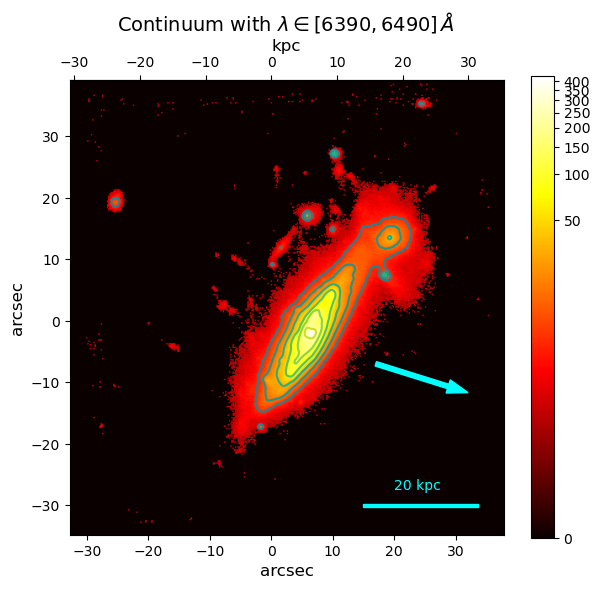

In [83]:
conti = data[0,:,:]

#makes the data smoother
from scipy.ndimage.filters import gaussian_filter
smoothConti = gaussian_filter(conti, sigma=.75)
contourVals = np.logspace(3,9,num=7,base = 2)
print("Values for the levels of the Contour map\n",contourVals)

#masking
contiMask = masking(conti,2,500)
normC = simple_norm(contiMask,"log")


#ploting
fig,ax = plt.subplots(1,1,figsize=(7,6))
imCM = ax.imshow(contiMask,norm = normC, origin='lower', cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imCM)
ax.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
ax.set_title(r"Continuum with $\lambda \in [6390,6490] \, \AA$ ",fontsize=14)
ax.set_xlabel("arcsec",fontsize=12)
ax.set_ylabel("arcsec",fontsize=12)
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="aqua")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="aqua")

dx = 20-5
dy = linhaGC(20) - linhaGC(5)
ax.arrow(17,-7, dx, dy, width=0.75, length_includes_head = True, color="aqua")

secax = ax.secondary_xaxis('top', functions=(arcsec2pc,pc2arcsec))
secax.set_xlabel("kpc",fontsize=12)
plt.savefig("Continuum")
plt.show()

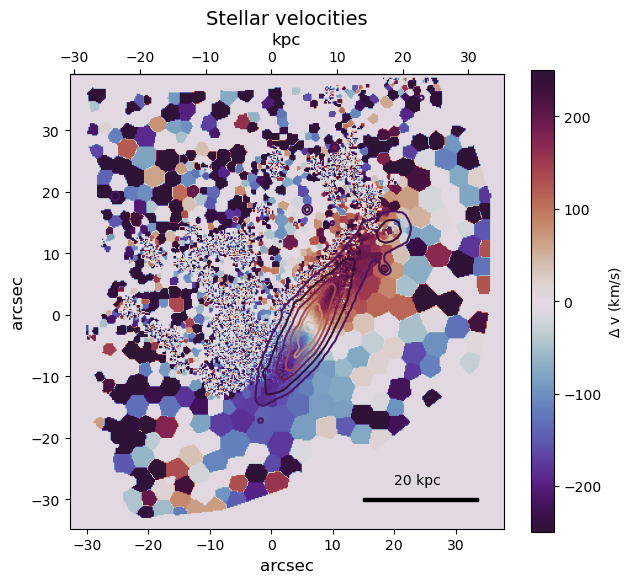

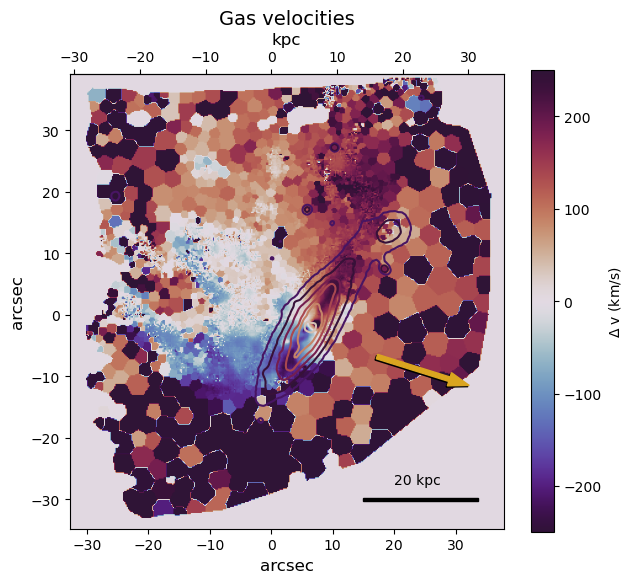

In [84]:
# Stellar velocities
Vel = data[5,:,:] 
VMask = masking2(Vel,-250,250)

fig,ax = plt.subplots(1,1,figsize=(7,6))
im = plt.imshow(VMask, origin='lower', cmap=plt.get_cmap("twilight_shifted"), extent=[x0,xf,y0,yf])
plt.colorbar(im, label="$\Delta$ v (km/s)");
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
plt.title("Stellar velocities",fontsize=14)
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="k")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="k")
secax = ax.secondary_xaxis('top', functions=(arcsec2pc,pc2arcsec))
secax.set_xlabel("kpc",fontsize=12)
# ax.arrow(17,-7, dx, dy, width=0.75, length_includes_head = True, color="k")

plt.savefig("Stellar vel.png")
plt.show()

# mean v of strongest lines
vGas = data[71,:,:] 
vGasMask = masking2(vGas,-250,250)

fig,ax = plt.subplots(1,1,figsize=(7,6))
im = plt.imshow(vGasMask, origin='lower', cmap=plt.get_cmap("twilight_shifted"), extent=[x0,xf,y0,yf])
plt.colorbar(im, label="$\Delta$ v (km/s)")
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
plt.title("Gas velocities",fontsize=14)
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="k")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="k")
secax = ax.secondary_xaxis('top', functions=(arcsec2pc,pc2arcsec))
secax.set_xlabel("kpc",fontsize=12)
ax.arrow(17,-7, dx, dy, width=0.75, length_includes_head = True, color="k")
ax.arrow(17.2,-6.8, dx, dy, width=0.75, length_includes_head = True, color="goldenrod")

plt.savefig("Gas vel.png")
plt.show()

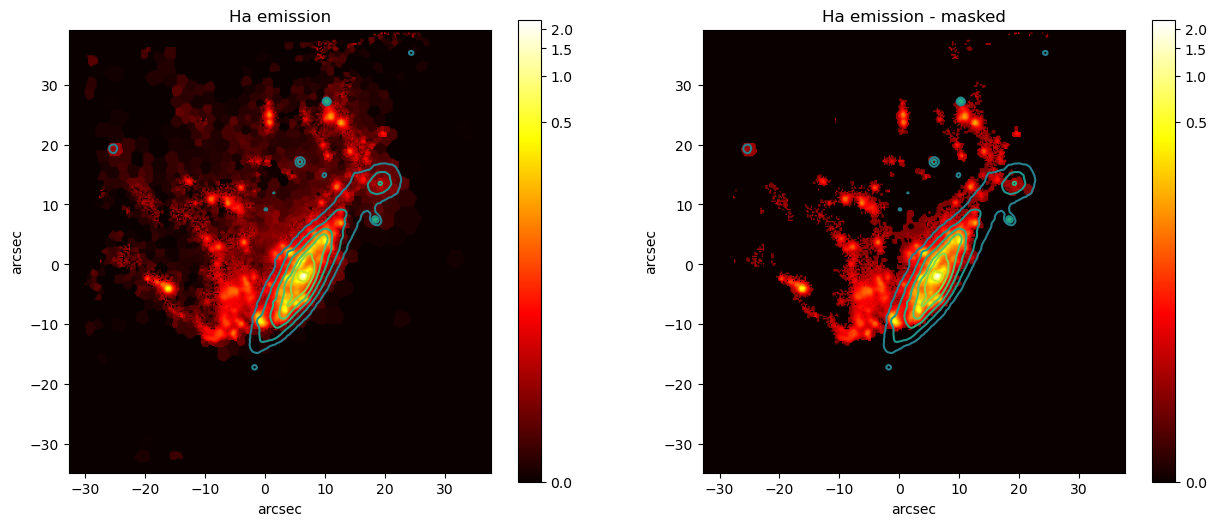

In [85]:
Ha = data[49,:,:]
maskHa = masking(Ha,5*10**-3,3)

plt.subplots(figsize=(15,6))
plt.subplot(1,2,1)
normHa = simple_norm(Ha, "log")
im4 = plt.imshow(Ha, origin='lower',norm=normHa, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im4);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Ha emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,2,2)
normHaM = simple_norm(maskHa, "log")
im4 = plt.imshow(maskHa, origin='lower',norm=normHaM, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im4);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Ha emission - masked")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

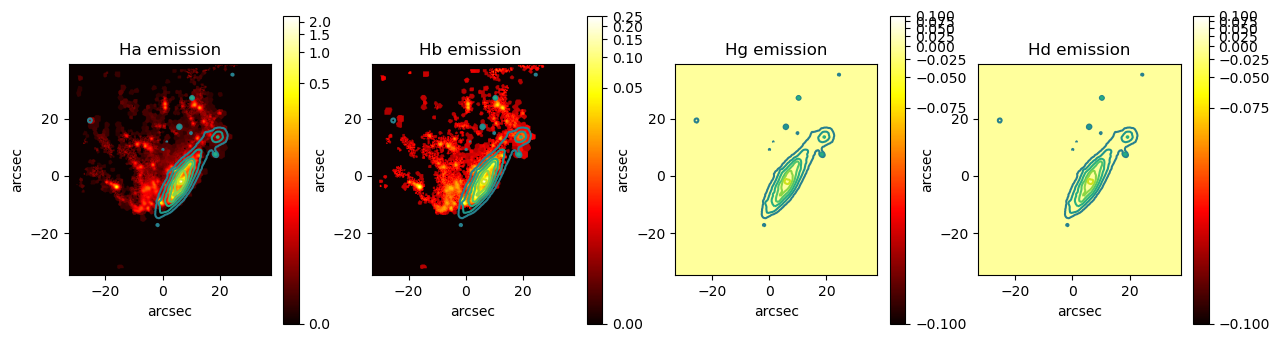

In [86]:

Ha = masking(data[49,:,:], 10**-3,3)
Hb = masking(data[39,:,:],10**-3,1)
Hg = data[33,:,:]
Hd = data[31,:,:]

plt.subplots(figsize=(15,4))
plt.subplot(1,4,1)
normHa = simple_norm(Ha, "log")
imHa = plt.imshow(Ha, origin='lower',norm=normHa, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imHa);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Ha emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,4,2)
normHb = simple_norm(Hb, "log")
imHb = plt.imshow(Hb, origin='lower',norm=normHb, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imHb);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Hb emission ")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,4,3)
normHg = simple_norm(Hg, "log")
imHg = plt.imshow(Hg, origin='lower',norm=normHg, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imHg);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Hg emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,4,4)
normHd = simple_norm(Hd, "log")
imHd = plt.imshow(Hd, origin='lower',norm=normHd, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imHd);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Hd emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

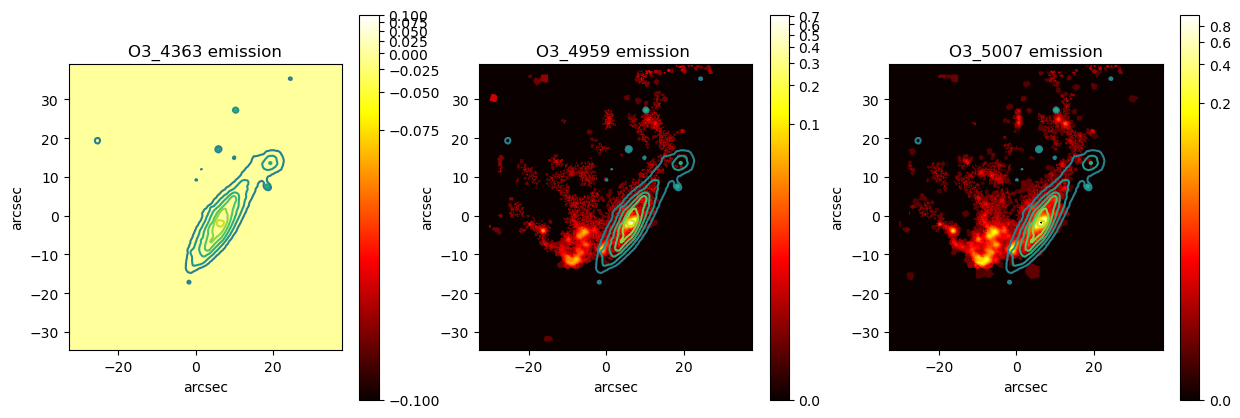

In [87]:
O3_4363 = masking(data[35,:,:], 0.01,0.2)
O3_4959 = masking(data[41,:,:], 10**-3,1)
O3_5007 = masking(data[43,:,:], 10**-3,1)

plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
normO3_4363 = simple_norm(O3_4363, "log")
imO3_4363 = plt.imshow(O3_4363, origin='lower',norm=normO3_4363, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imO3_4363)
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("O3_4363 emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,3,2)
normO3_4959 = simple_norm(O3_4959, "log")
imO3_4959 = plt.imshow(O3_4959, origin='lower',norm=normO3_4959, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imO3_4959)
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("O3_4959 emission ")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.subplot(1,3,3)
normO3_5007  = simple_norm(O3_5007 , "log")
imO3_5007  = plt.imshow(O3_5007 , origin='lower',norm=normO3_5007 , cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(imO3_5007 );
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("O3_5007 emission")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


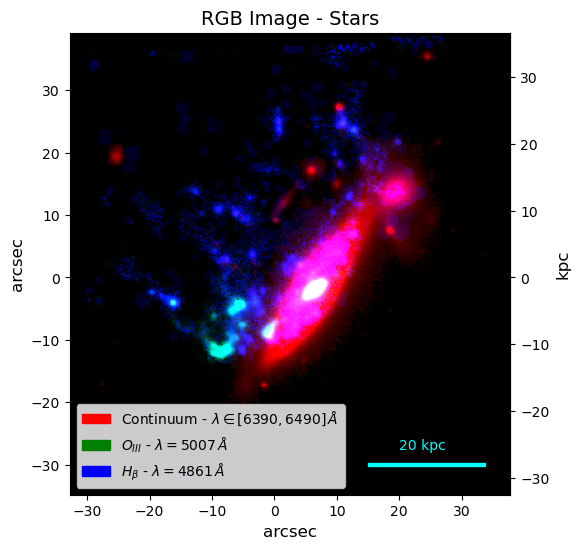

In [88]:
#### Pretty Picture ####

con = data[0,:,:]
conM = masking(con,1.9,500)
normC = simple_norm(conM,"log")

O3_5007 = data[43,:,:]
O3M = masking(O3_5007,10**-3,3)
normO3 = simple_norm(O3M, "log")

Hb = data[39,:,:]
HbM = masking(Hb,10**-3,3)
normHb = simple_norm(HbM,"log")

# Plot colors individually
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(conM, origin='lower', norm=normC, cmap=plt.get_cmap("Reds"), extent=[x0,xf,y0,yf])
# axs[0].set_title("Ha emission (Red)")
# axs[1].imshow(O3M, origin='lower', norm=normO3, cmap=plt.get_cmap("Greens"), extent=[x0,xf,y0,yf])
# axs[1].set_title("O3 5007 emission (Green)")
# axs[2].imshow(HbM, origin='lower', norm=normHb, cmap=plt.get_cmap("Blues"), extent=[x0,xf,y0,yf])
# axs[2].set_title("Hb log map (Blue)")
# for ax in axs:
#     ax.set_xlabel("arcsec")
#     ax.set_ylabel("arcsec")
# plt.show()



# Plot RGB picture
intensity = 25                                # intensity domain is [0,255]              
contiNorm = conM / np.max(conM)*intensity       # contiNorm domain is [0,1] * intensity
O3_5007Norm = O3M / np.max(O3M)*intensity
HbNorm = HbM / np.max(HbM)*intensity


RGBval = (np.dstack((contiNorm,O3_5007Norm,HbNorm)))
normRGB = simple_norm(RGBval,"log")



fig,ax = plt.subplots(1,1,figsize=(7,6))
ax.imshow(RGBval, origin='lower',norm=normRGB, extent=[x0,xf,y0,yf])
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="aqua")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="aqua")
secax = ax.secondary_yaxis('right', functions=(arcsec2pc,pc2arcsec))
secax.set_ylabel("kpc",fontsize=12)
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
plt.title("RGB Image - Stars",fontsize=14)
red_patch = mpatches.Patch(color='red', label=r'Continuum - $\lambda \in [6390,6490] \, \AA$ ')
green_patch = mpatches.Patch(color='green', label=r'$O_{III}$ - $\lambda = 5007 \, \AA$ ')
blue_patch = mpatches.Patch(color='blue', label=r'$H_\beta$ - $\lambda = 4861 \, \AA$ ')
plt.legend(loc="lower left",handles=[red_patch,green_patch, blue_patch])
plt.savefig("JO204 RGB.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


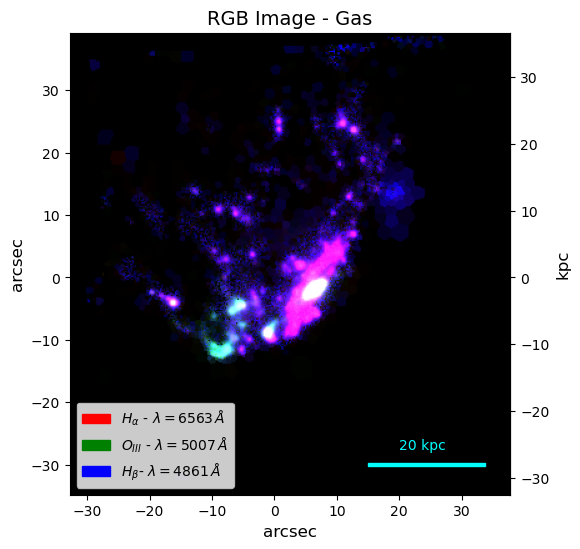

In [89]:
#### Pretty Picture ####

Ha = data[49,:,:]
HaM = masking(Ha, 10**-3,3)
normHa = simple_norm(HaM, "log")

O3_5007 = data[43,:,:]
O3M = masking(O3_5007,10**-3,3)
normO3 = simple_norm(O3M, "log")

Hb = data[39,:,:]
HbM = masking(Hb,10**-3,3)
normHb = simple_norm(HbM,"log")

# Plot colors individually
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(HaM, origin='lower', norm=normHa, cmap=plt.get_cmap("Reds"), extent=[x0,xf,y0,yf])
# axs[0].set_title("Ha emission (Red)")
# axs[1].imshow(O3M, origin='lower', norm=normO3, cmap=plt.get_cmap("Greens"), extent=[x0,xf,y0,yf])
# axs[1].set_title("O3 5007 emission (Green)")
# axs[2].imshow(HbM, origin='lower', norm=normHb, cmap=plt.get_cmap("Blues"), extent=[x0,xf,y0,yf])
# axs[2].set_title("Hb log map (Blue)")
# for ax in axs:
#     ax.set_xlabel("arcsec")
#     ax.set_ylabel("arcsec")
# plt.show()


# Plot RGB picture
intensity = 25                               # intensity domain is [0,255]
HaNorm = HaM / np.max(HaM) *intensity               # HaNorm domain is [0,1] * intensity
O3_5007Norm = O3M / np.max(O3M)*intensity
HbNorm = HbM / np.max(HbM)*intensity

RGBval2 = (np.dstack((HaNorm,O3_5007Norm,HbNorm)))
normRGB2 = simple_norm(RGBval2,"log")

fig,ax = plt.subplots(1,1,figsize=(7,6))
ax.imshow(RGBval2, origin='lower',norm=normRGB2, extent=[x0,xf,y0,yf])
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="aqua")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="aqua")
secax = ax.secondary_yaxis('right', functions=(arcsec2pc,pc2arcsec))
secax.set_ylabel("kpc",fontsize=12)
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
plt.title("RGB Image - Gas",fontsize=14)
red_patch = mpatches.Patch(color='red', label=r'$H_\alpha$ - $\lambda  = 6563 \, \AA$ ')
green_patch = mpatches.Patch(color='green', label=r'$O_{III}$ - $\lambda = 5007 \, \AA$')
blue_patch = mpatches.Patch(color='blue', label=r'$H_\beta$- $\lambda = 4861 \, \AA$')
plt.legend(loc="lower left",handles=[red_patch,green_patch, blue_patch])
plt.savefig("JO204 RGB2.png")
plt.show()

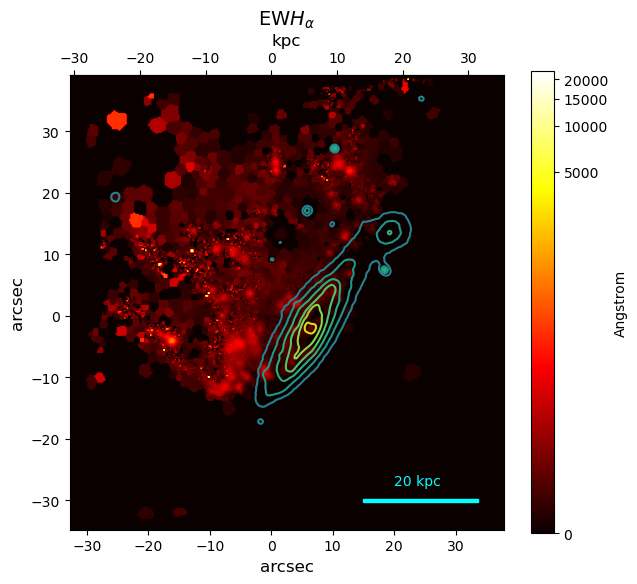

In [90]:
EWHa = data[51,:,:]

EWHa_mask = masking(EWHa, 6,10**6)
norma = simple_norm(EWHa_mask,"log")

fig,ax = plt.subplots(1,1,figsize=(7,6))
im = ax.imshow(EWHa_mask, origin='lower',norm=norma, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im,label="Angstrom")
ax.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
ax.set_xlabel("arcsec",fontsize=12)
ax.set_ylabel("arcsec",fontsize=12)
ax.arrow(15,-30,18.706,0, width=0.5,head_width=0,color="aqua")
ax.text(20, -27.5, '20 kpc', fontsize=10,color="aqua")
secax = ax.secondary_xaxis('top', functions=(arcsec2pc,pc2arcsec))
secax.set_xlabel("kpc",fontsize=12)
plt.title(r"EW$H_\alpha$",fontsize=14)
plt.savefig("EWHa.png")
plt.show()

C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3541975935.py:41: RuntimeWarning: divide by zero encountered in log10
  x_N2Ha[c] = np.log10(N2Ha[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3541975935.py:40: RuntimeWarning: invalid value encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3541975935.py:40: RuntimeWarning: divide by zero encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])


30543 0.037636421823002975 0.006075729279060527
0.905269980430603 0.1408820003271103


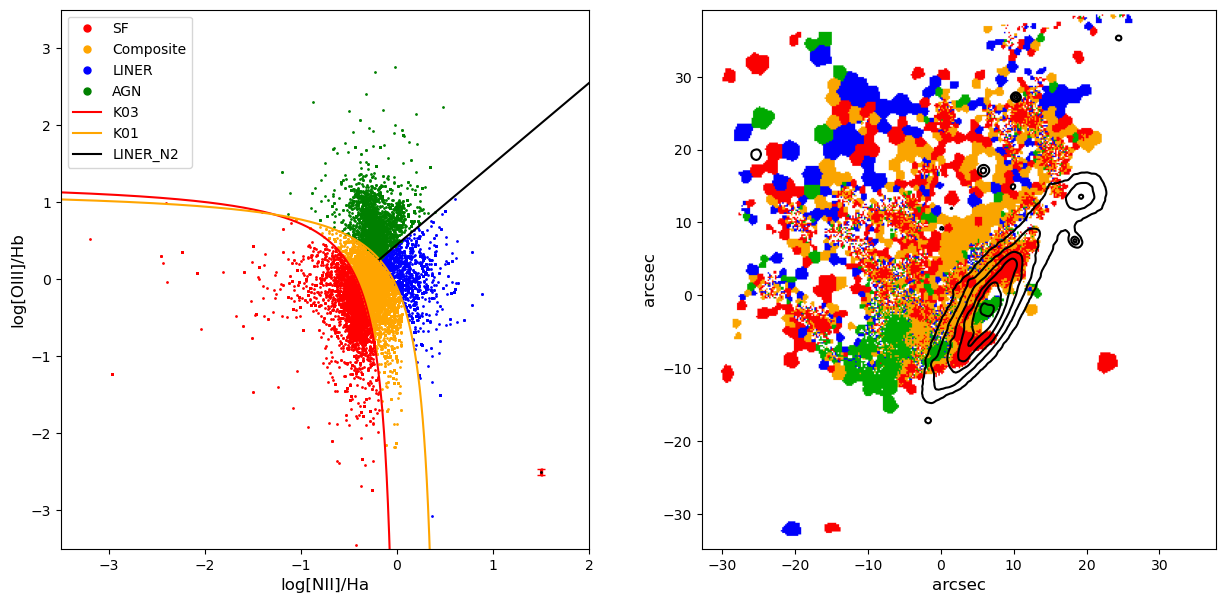

In [91]:
def K03(x):                         #(Kauffmann+03 line)
    return  0.61 / (x - 0.05) + 1.3 # x vem em log
def K01(x):                         # (Kewley+01 line)
    return 0.61 / (x - 0.47) + 1.19
def LINER_N2(x):
    return 1.05 * x + 0.45          #(LINER/Sy2 line)

O3Hb = data[15,:,:]
O3HbSig = maskAbs(data[16,:,:])
N2Ha = data[17,:,:]
N2HaSig = maskAbs(data[18,:,:])


Nvals = len(O3Hb[0,:]) * len(O3Hb[:,0])
x_N2Ha = np.zeros(Nvals)
y_O3Hb = np.zeros(Nvals)
y_SF = np.array([])
x_SF = np.array([])
y_Comp = np.array([])
x_Comp = np.array([])
y_L = np.array([])
x_L = np.array([])
y_AGN = np.array([])
x_AGN = np.array([])
sigO3Hb = np.array([])
sigN2Ha = np.array([])


cores = np.array(  [[255, 255, 255],   # white
                    [250,   0,   0],   # red
                    [  0, 170,   0],   # green
                    [  0,   0, 250],   # blue
                    [250, 165,   0]])  # orange
BeW = np.zeros([370,353],dtype=int)

c = 0
for j in range(len(O3Hb[0,:])):
    for i in range(len(O3Hb[:,0])):
        if 6 <= EWHa[i,j] :
            y_O3Hb[c] = np.log10(O3Hb[i,j])
            x_N2Ha[c] = np.log10(N2Ha[i,j])
            
            # Star Formation
            if y_O3Hb[c] < K03(x_N2Ha[c]) and x_N2Ha[c] < 0:
                y_SF = np.append(y_SF,y_O3Hb[c])
                x_SF = np.append(x_SF,x_N2Ha[c]) 
                BeW[i,j] = 1.0
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigN2Ha = np.append(sigN2Ha, (N2HaSig[i,j]))
            # Composite
            elif K03(x_N2Ha[c]) < y_O3Hb[c] < K01(x_N2Ha[c]) or y_O3Hb[c] < K01(x_N2Ha[c]) and x_N2Ha[c] < 0:
                y_Comp = np.append(y_Comp,y_O3Hb[c])
                x_Comp = np.append(x_Comp,x_N2Ha[c]) 
                BeW[i,j] = 4.0
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigN2Ha = np.append(sigN2Ha, (N2HaSig[i,j]))
            # LINERs
            elif K01(x_N2Ha[c]) < y_O3Hb[c] < LINER_N2(x_N2Ha[c]) or 0.3 < x_N2Ha[c] and y_O3Hb[c] < LINER_N2(x_N2Ha[c]):
                y_L = np.append(y_L,y_O3Hb[c])
                x_L = np.append(x_L,x_N2Ha[c]) 
                BeW[i,j] = 3.0
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigN2Ha = np.append(sigN2Ha, (N2HaSig[i,j]))
            #AGNs
            elif (K01(x_N2Ha[c]) < y_O3Hb[c] or 0.3 < x_N2Ha[c]) and LINER_N2(x_N2Ha[c])< y_O3Hb[c] :
                y_AGN = np.append(y_AGN,y_O3Hb[c])
                x_AGN = np.append(x_AGN,x_N2Ha[c])
                BeW[i,j] = 2.0
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigN2Ha = np.append(sigN2Ha, (N2HaSig[i,j]))
            c += 1
        
# theory lines
xKauff = np.linspace(-4,0,10**4)
yKauff = K03(xKauff)    
xKew = np.linspace(-4,0.35,10**4)
yKew = K01(xKew)
xLINER = np.linspace(-0.1838,4,10**4) #calculei ponto interseção
yLINER = LINER_N2(xLINER)

BarraO3Hb = np.log10(statistics.median(sigO3Hb)+10)-1
BarraN2Ha = np.log10(statistics.median(sigN2Ha)+10)-1
print(len(sigO3Hb),BarraO3Hb,BarraN2Ha)
print(statistics.median(sigO3Hb),statistics.median(sigN2Ha))

plt.subplots(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x_SF, y_SF,    ".",ms=2,label="SF",color="r")
plt.plot(x_Comp, y_Comp,".",ms=2,label="Composite",color="orange")
plt.plot(x_L, y_L,      ".",ms=2,label="LINER",color="b")
plt.plot(x_AGN, y_AGN,  ".",ms=2,label="AGN",color="g")
plt.plot(xKauff,yKauff, label="K03", color="red")
plt.plot(xKew,  yKew,   label="K01", color="orange")
plt.plot(xLINER,yLINER, label="LINER_N2", color="k")
plt.errorbar(1.5, -2.5, yerr=BarraO3Hb, xerr=BarraN2Ha,fmt=".",ms=2, color="k", ecolor="red", capsize=2.7 )
plt.xlim(-3.5,2)
plt.ylim(-3.5,3.5)
plt.xlabel("log[NII]/Ha",fontsize=12)
plt.ylabel("log[OIII]/Hb",fontsize=12)
plt.legend(markerscale=5)

plt.subplot(1,2,2)
final = cores[BeW]
normBPT = simple_norm(final,"log")
plt.imshow(final, origin='lower',norm=normBPT, extent=[x0,xf,y0,yf])
plt.contour(smoothConti, norm=normC, levels=contourVals,origin='lower',colors="k", extent=[x0,xf,y0,yf])
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
#plt.title(r"(OIII/$H_\beta$ ) / (NII/$H_\alpha$)")
plt.savefig("BPT O3N2.png")
plt.show()

C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3470832821.py:33: RuntimeWarning: divide by zero encountered in log10
  x_S2Ha[c] = np.log10(S2Ha[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3470832821.py:34: RuntimeWarning: invalid value encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\3470832821.py:34: RuntimeWarning: divide by zero encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])


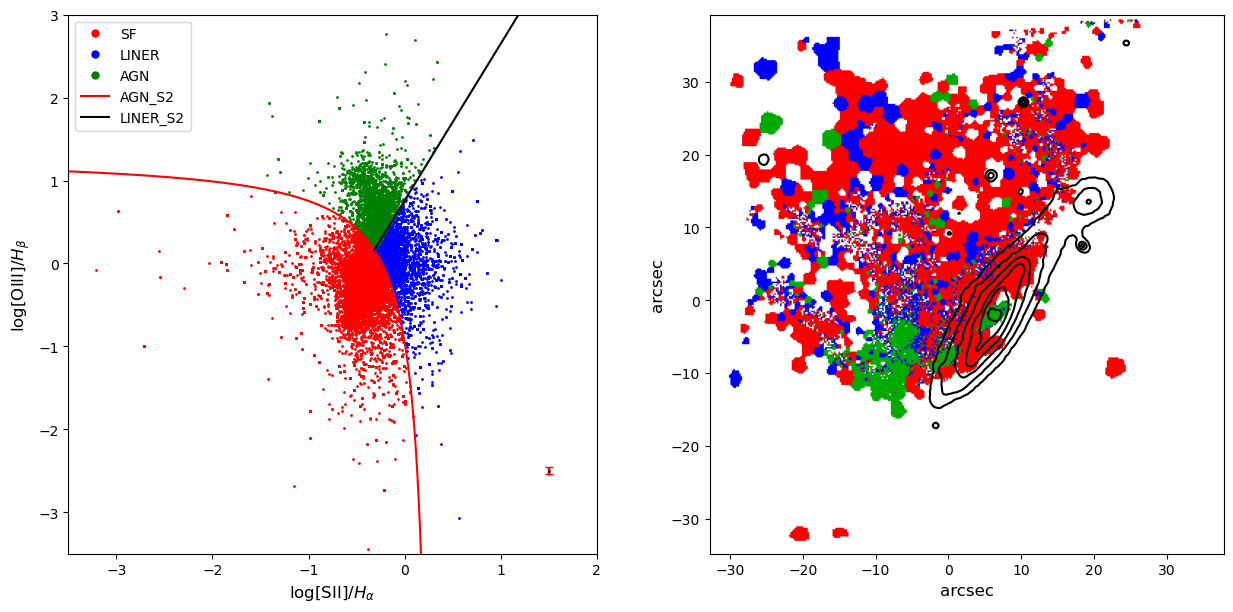

In [92]:
def AGN_S2(x):
    return 0.72 / (x - 0.32) + 1.30    #(main AGN line)
def LINER_S2(x):
    return 1.89 * x + 0.76           #(LINER/Sy2 line)

S2Ha = data[19,:,:]
S2HaSig = data[20,:,:]

x_S2Ha = np.zeros(Nvals)
y_O3Hb = np.zeros(Nvals)
y_SF = np.array([])
x_SF = np.array([])
y_L = np.array([])
x_L = np.array([])
y_AGN = np.array([])
x_AGN = np.array([])
sigO3Hb = np.array([])
sigS2Ha = np.array([])
c = 0

cores = np.array(  [[255, 255, 255],   # white
                    [250,   0,   0],   # red
                    [  0, 170,   0],   # green
                    [  0,   0, 250],   # blue
                    [250, 165,   0]])  # orange

BeW = np.zeros([370,353],dtype=int)


for j in range(len(O3Hb[0,:])):
    for i in range(len(O3Hb[:,0])):
        if 6 <= EWHa[i,j] :
            x_S2Ha[c] = np.log10(S2Ha[i,j])
            y_O3Hb[c] = np.log10(O3Hb[i,j])

            # Star Formation
            if y_O3Hb[c] < AGN_S2(x_S2Ha[c]) and x_S2Ha[c] < 0.3:
                y_SF = np.append(y_SF,y_O3Hb[c])
                x_SF = np.append(x_SF,x_S2Ha[c])
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigS2Ha = np.append(sigS2Ha, (S2HaSig[i,j]))
                BeW[i,j] = 1.0
            # LINERs
            elif AGN_S2(x_S2Ha[c]) < y_O3Hb[c] < LINER_S2(x_S2Ha[c]) or x_S2Ha[c] > 0.3 and y_O3Hb[c] < LINER_S2(x_S2Ha[c]):
                y_L = np.append(y_L,y_O3Hb[c])
                x_L = np.append(x_L,x_S2Ha[c]) 
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigS2Ha = np.append(sigS2Ha, (S2HaSig[i,j]))
                BeW[i,j] = 3.0
            #AGNs
            elif (AGN_S2(x_S2Ha[c]) < y_O3Hb[c] or x_S2Ha[c] > 0.3) and LINER_S2(x_S2Ha[c]) < y_O3Hb[c]:
                y_AGN = np.append(y_AGN,y_O3Hb[c])
                x_AGN = np.append(x_AGN,x_S2Ha[c])
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigS2Ha = np.append(sigS2Ha, (S2HaSig[i,j]))
                BeW[i,j] = 2.0

            c += 1
        
# theory lines
xAGN = np.linspace(-4,0.3,10**4)
yAGN = AGN_S2(xAGN)
xLINER = np.linspace(-0.3146,4,10**4) # I calculated the intersection point
yLINER = LINER_S2(xLINER)

BarraO3Hb = np.log10(statistics.median(sigO3Hb)+10)-1
BarraS2Ha = np.log10(statistics.median(sigS2Ha)+10)-1

plt.subplots(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x_SF, y_SF,    ".",ms=2,label="SF",color="r")
plt.plot(x_L, y_L,      ".",ms=2,label="LINER",color="b")
plt.plot(x_AGN, y_AGN,  ".",ms=2,label="AGN",color="g")
plt.plot(xAGN, yAGN,    label="AGN_S2",color="red")
plt.plot(xLINER, yLINER,label="LINER_S2", color="k")
plt.errorbar(1.5, -2.5, yerr=BarraO3Hb, xerr=BarraS2Ha,fmt=".",ms=2, color="k", ecolor="red", capsize=2.7 )
plt.xlim(-3.5,2)
plt.ylim(-3.5,3)
plt.xlabel(r"log[SII]/$H_\alpha$",fontsize=12)
plt.ylabel(r"log[OIII]/$H_\beta$",fontsize=12)
plt.legend(markerscale=5)

plt.subplot(1,2,2)
final = cores[BeW]
normBPT = simple_norm(final,"log")
plt.imshow(final, origin='lower',norm=normBPT, extent=[x0,xf,y0,yf])
plt.contour(smoothConti, norm=normC, levels=contourVals,origin='lower',colors="k", extent=[x0,xf,y0,yf])
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
#plt.title(r"(OIII/$H_\beta$) / (SII/$H_\alpha$)")
plt.savefig("BPT O3S2.png")
plt.show()

C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\294739929.py:33: RuntimeWarning: divide by zero encountered in log10
  x_O1Ha[c] = np.log10(O1Ha[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\294739929.py:34: RuntimeWarning: invalid value encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])
C:\Users\tiago\AppData\Local\Temp\ipykernel_23524\294739929.py:34: RuntimeWarning: divide by zero encountered in log10
  y_O3Hb[c] = np.log10(O3Hb[i,j])


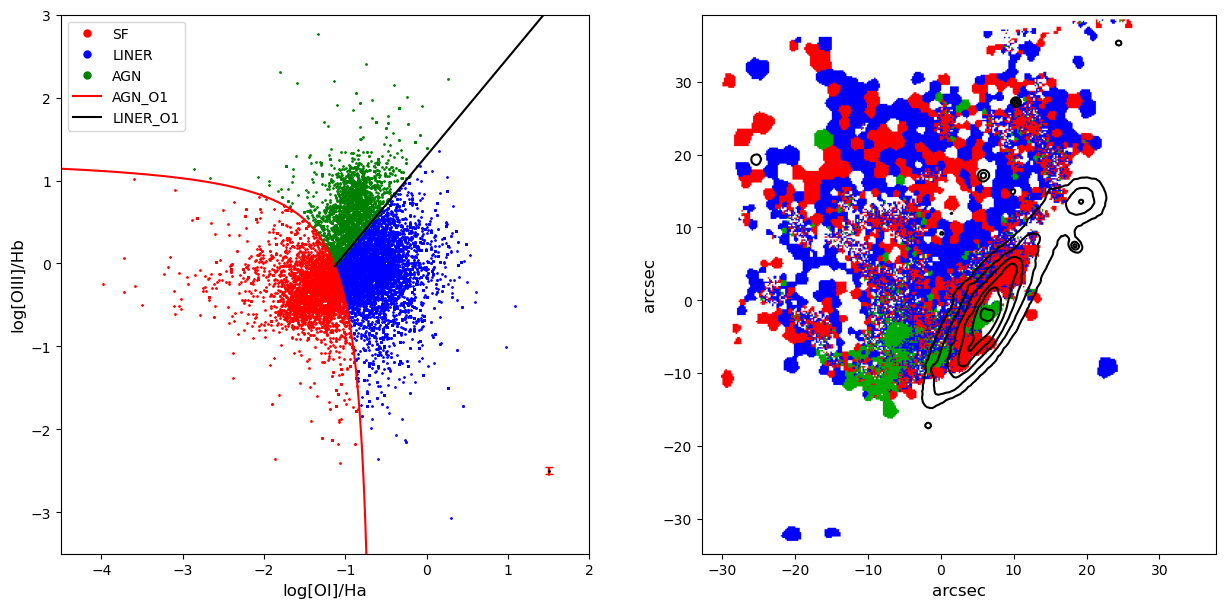

In [93]:
def AGN_O1(x):
    return 0.73 / (x +0.59) + 1.33    #(main AGN line)
def LINER_O1(x):
    return 1.18 * x + 1.30           #(LINER/Sy2 line)

O1Ha = data[21,:,:]
O1HaSig = data[22,:,:]

x_O1Ha = np.zeros(Nvals)
y_O3Hb = np.zeros(Nvals)
y_SF = np.array([])
x_SF = np.array([])
y_L = np.array([])
x_L = np.array([])
y_AGN = np.array([])
x_AGN = np.array([])
sigO3Hb = np.array([])
sigO1Ha = np.array([])
c = 0

cores = np.array(  [[255, 255, 255],   # white
                    [250,   0,   0],   # red
                    [  0, 170,   0],   # green
                    [  0,   0, 250],   # blue
                    [250, 165,   0]])  # orange

BeW = np.zeros([370,353],dtype=int)


for j in range(len(O3Hb[0,:])):
    for i in range(len(O3Hb[:,0])):
        if 6 <= EWHa[i,j] :
            x_O1Ha[c] = np.log10(O1Ha[i,j])
            y_O3Hb[c] = np.log10(O3Hb[i,j])

              # Star Formation
            if y_O3Hb[c] < AGN_O1(x_O1Ha[c]) and x_O1Ha[c]<-0.7:
                y_SF = np.append(y_SF,y_O3Hb[c])
                x_SF = np.append(x_SF,x_O1Ha[c])
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigO1Ha = np.append(sigS2Ha, (O1HaSig[i,j]))
                BeW[i,j] = 1.0
            # LINERs
            elif AGN_O1(x_O1Ha[c]) < y_O3Hb[c] < LINER_O1(x_O1Ha[c]) or y_O3Hb[c] < LINER_O1(x_O1Ha[c]) and -0.7<x_O1Ha[c] :
                y_L = np.append(y_L,y_O3Hb[c])
                x_L = np.append(x_L,x_O1Ha[c]) 
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigO1Ha = np.append(sigS2Ha, (O1HaSig[i,j]))
                BeW[i,j] = 3.0
            #AGNs
            elif AGN_O1(x_O1Ha[c]) < y_O3Hb[c] > LINER_O1(x_O1Ha[c]) or y_O3Hb[c] > LINER_O1(x_O1Ha[c]) and -0.7<x_O1Ha[c]:
                y_AGN = np.append(y_AGN,y_O3Hb[c])
                x_AGN = np.append(x_AGN,x_O1Ha[c]) 
                sigO3Hb = np.append(sigO3Hb, (O3HbSig[i,j]))
                sigO1Ha = np.append(sigS2Ha, (O1HaSig[i,j]))
                BeW[i,j] = 2.0

            c += 1

# theory lines
xAGN = np.linspace(-6,-0.7,10**4)
yAGN = AGN_O1(xAGN)
xLINER = np.linspace(-1.1269,4,10**4)
yLINER = LINER_O1(xLINER)

#error bar
BarraO3Hb = np.log10(statistics.median(sigO3Hb)+10)-1
BarraO1Ha = np.log10(statistics.median(sigO1Ha)+10)-1

plt.subplots(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x_SF, y_SF,    ".",ms=2,label="SF",color="r")
plt.plot(x_L, y_L,      ".",ms=2,label="LINER",color="b")
plt.plot(x_AGN, y_AGN,  ".",ms=2,label="AGN",color="g")
plt.plot(xAGN, yAGN,    label="AGN_O1", color="red")
plt.plot(xLINER, yLINER,label="LINER_O1", color="k")
plt.errorbar(1.5, -2.5, yerr=BarraO3Hb, xerr=BarraO1Ha,fmt=".",ms=2, color="k", ecolor="red", capsize=2.7 )
plt.xlim(-4.5,2)
plt.ylim(-3.5,3)
plt.xlabel("log[OI]/Ha",fontsize=12)
plt.ylabel("log[OIII]/Hb",fontsize=12)
plt.legend(markerscale=5)

plt.subplot(1,2,2)
final = cores[BeW]
normBPT = simple_norm(final,"log")
plt.imshow(final, origin='lower',norm=normBPT, extent=[x0,xf,y0,yf])
plt.contour(smoothConti, norm=normC, levels=contourVals,origin='lower',colors="k", extent=[x0,xf,y0,yf])
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)
#plt.title(r"(OIII/$H_\beta$) / (OI/$H_\alpha$)")
plt.savefig("BPT O3O1.png")
plt.show()

In [94]:
vGas = data[71,:,:] # mean v of strongest lines
vGasMask = masking2(vGas,-250,250)

def f1(x):
    return 1.55*x - 11.5
def f2(x):
    return 1.55*x - 8.5
def f3(x):
    return 1.55*x - 5.5
def f4(x):
    return 1.55*x - 2.5
def f5(x):
    return 1.55*x + 0.5

xs1 = np.linspace(-2,14,10**4)
ys1 = f1(xs1)
xs2 = np.linspace(-3.5,12.5,10**4)
ys2 = f2(xs2)
xs3 = np.linspace(-5,11,10**4)
ys3 = f3(xs3)
xs4 = np.linspace(-6.5,9.5,10**4)
ys4 = f4(xs4)
xs5 = np.linspace(-8,8,10**4)
ys5 = f5(xs5)


# Pt interseção ylinha1 com centro galáxia
xC = 6.20
yC = f1(xC)

# reta perpendicular que passa no centro
def fC(x):
    bC = yC + 1/1.5*xC
    return -1/1.5*x + bC

xN = xC +2
yN = yC - f1(-2)
tet = np.arctan(yN/xN)
lVal = xN/np.cos(tet)
print("O centro da galáxia é quando l =",lVal)

linha1 = np.array([])
xlinha1 = np.array([])
linha2 = np.array([])
xlinha2 = np.array([])
linha3 = np.array([])
xlinha3 = np.array([])
linha4 = np.array([])
xlinha4 = np.array([])
linha5 = np.array([])
xlinha5 = np.array([])
linha6 = np.array([])

y1 = np.array([])

l1 = np.array([])
l2 = np.array([])
l3 = np.array([])
l4 = np.array([])
l5 = np.array([])


incerteza = 0.15
for i in range(353):
    for j in range(370):
        yVal = i *0.2 - 32.8
        xVal = - 370*0.2 + j*0.2 + 39.2
        
        if yVal-incerteza<= f1(xVal) <= yVal+incerteza and -2<=xVal<=14:
            linha1 = np.append(linha1, vGasMask[i,j])
            xlinha1 = np.append(xlinha1, xVal)
            y1 = np.append(y1, yVal)
            xNovo = xVal +2
            yNovo = yVal - f1(-2)
            teta = np.arctan(yNovo/xNovo)
            l1 = np.append(l1, xNovo/np.cos(teta))
        if yVal-incerteza<= f2(xVal) <= yVal+incerteza and -3.5<=xVal<=12.5:
            linha2 = np.append(linha2, vGasMask[i,j])
            xlinha2 = np.append(xlinha2, xVal)
            xNovo = xVal +3.51
            yNovo = yVal - f2(-3.5)
            teta = np.arctan(yNovo/xNovo)
            l2 = np.append(l2, xNovo/np.cos(teta))
        if yVal-incerteza<= f3(xVal) <= yVal+incerteza and -5<=xVal<=11:
            linha3 = np.append(linha3, vGasMask[i,j])
            xlinha3 = np.append(xlinha3, xVal)
            xNovo = xVal +5.01
            yNovo = yVal - f3(-5)
            teta = np.arctan(yNovo/xNovo)
            l3 = np.append(l3, xNovo/np.cos(teta))
        if yVal-incerteza<= f4(xVal) <= yVal+incerteza and -6.5<=xVal<=9.5:
            linha4 = np.append(linha4, vGasMask[i,j])
            xlinha4 = np.append(xlinha4, xVal)
            xNovo = xVal +6.51
            yNovo = yVal - f4(-6.5)
            teta = np.arctan(yNovo/xNovo)
            l4 = np.append(l4, xNovo/np.cos(teta))
        if yVal-incerteza<= f5(xVal) <= yVal+incerteza and -8<=xVal<=8:
            linha5 = np.append(linha5, vGasMask[i,j])
            xlinha5 = np.append(xlinha5, xVal)
            xNovo = xVal +8.01
            yNovo = yVal - f5(-8)
            teta = np.arctan(yNovo/xNovo)
            l5 = np.append(l5, xNovo/np.cos(teta))

sigma =2
ylinha1 = sc.ndimage.filters.gaussian_filter1d(linha1,sigma)
ylinha2 = sc.ndimage.filters.gaussian_filter1d(linha2,sigma)
ylinha3 = sc.ndimage.filters.gaussian_filter1d(linha3,sigma)
ylinha4 = sc.ndimage.filters.gaussian_filter1d(linha4,sigma)
ylinha5 = sc.ndimage.filters.gaussian_filter1d(linha5,sigma)

O centro da galáxia é quando l = 15.125610731471308


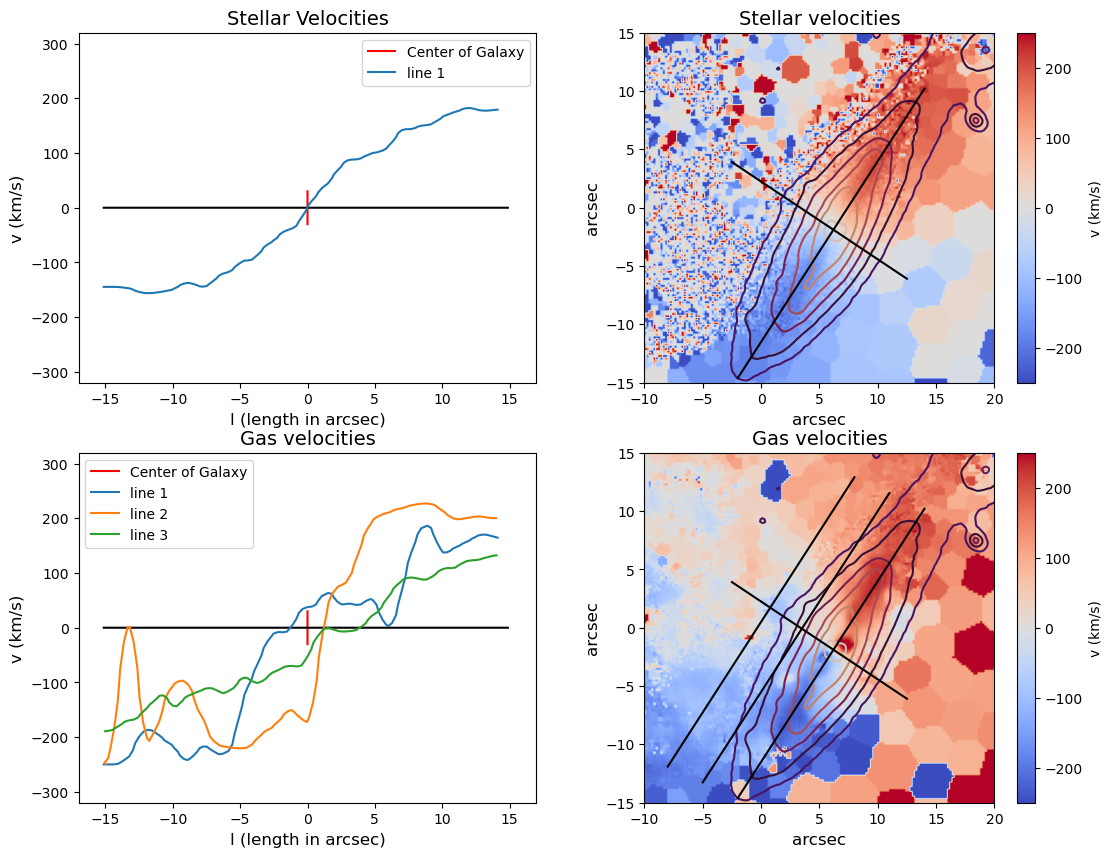

In [95]:
# Stellar velocities
Vel = data[5,:,:] 
VMask2 = masking2(Vel,-250,250)

linha1_S = np.array([])
xlinha1_S = np.array([])
linha2_S = np.array([])
xlinha2_S = np.array([])
linha3_S = np.array([])
xlinha3_S = np.array([])
linha4_S= np.array([])
xlinha4_S = np.array([])
linha5_S= np.array([])
xlinha5_S = np.array([])

y1_S = np.array([])

l1_S = np.array([])
l2_S = np.array([])
l3_S = np.array([])
l4_S = np.array([])
l5_S = np.array([])


incerteza = 0.15
for i in range(353):
    for j in range(370):
        yVal = i *0.2 - 32.8
        xVal = - 370*0.2 + j*0.2 + 39.2
        
        if yVal-incerteza<= f1(xVal) <= yVal+incerteza and -2<=xVal<=14:
            linha1_S = np.append(linha1_S, VMask2[i,j])
            xlinha1_S = np.append(xlinha1_S, xVal)
            y1_S = np.append(y1_S, yVal)
            xNovo = xVal +2
            yNovo = yVal - f1(-2)
            teta = np.arctan(yNovo/xNovo)
            l1_S = np.append(l1_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f2(xVal) <= yVal+incerteza and -3.5<=xVal<=12.5:
            linha2_S = np.append(linha2_S, VMask2[i,j])
            xlinha2_S = np.append(xlinha2_S, xVal)
            xNovo = xVal +3.51
            yNovo = yVal - f2(-3.5)
            teta = np.arctan(yNovo/xNovo)
            l2_S = np.append(l2_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f3(xVal) <= yVal+incerteza and -5<=xVal<=11:
            linha3_S = np.append(linha3_S, VMask2[i,j])
            xlinha3_S = np.append(xlinha3_S, xVal)
            xNovo = xVal +5.01
            yNovo = yVal - f3(-5)
            teta = np.arctan(yNovo/xNovo)
            l3_S = np.append(l3_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f4(xVal) <= yVal+incerteza and -6.5<=xVal<=9.5:
            linha4_S = np.append(linha4_S, VMask2[i,j])
            xlinha4_S = np.append(xlinha4_S, xVal)
        if yVal-incerteza<= f5(xVal) <= yVal+incerteza and -8<=xVal<=8:
            linha5_S = np.append(linha5_S, VMask2[i,j])
            xlinha5_S = np.append(xlinha5_S, xVal)
            xNovo = xVal +8.01
            yNovo = yVal - f5(-8)
            teta = np.arctan(yNovo/xNovo)
            l5_S = np.append(l5_S, xNovo/np.cos(teta))
            

ylinha1_S = sc.ndimage.filters.gaussian_filter1d(linha1_S,sigma)
ylinha2_S = sc.ndimage.filters.gaussian_filter1d(linha2_S,sigma)
ylinha3_S = sc.ndimage.filters.gaussian_filter1d(linha3_S,sigma)
ylinha4_S = sc.ndimage.filters.gaussian_filter1d(linha4_S,sigma)
ylinha5_S = sc.ndimage.filters.gaussian_filter1d(linha5_S,sigma)



plt.subplots(2,2,figsize=(13,10))
plt.subplot(2,2,3)
plt.plot(np.ones(10**4)*lVal-lVal,np.linspace(-30,30,10**4),color="red",label="Center of Galaxy")
plt.plot(np.linspace(0,30,10**4)-lVal,np.zeros(10**4),color="k")
plt.plot(l1-lVal,ylinha1,label=("line 1"))
#plt.plot(l2,ylinha2,label=("line 2"))
plt.plot(l3-lVal,ylinha3,label=("line 2"))
#plt.plot(l4,ylinha4,label=("line 4"))
plt.plot(l5-lVal,ylinha5,label=("line 3"))
plt.legend()
plt.xlim(-17,17)
plt.ylim(-320,320)
plt.xlabel("l (length in arcsec)",fontsize=12)
plt.ylabel("v (km/s)",fontsize=12)
plt.title("Gas velocities",fontsize=14)

plt.subplot(2,2,1)
plt.plot(np.ones(10**4)*lVal-lVal,np.linspace(-30,30,10**4),color="red",label="Center of Galaxy")
plt.plot(np.linspace(0,30,10**4)-lVal,np.zeros(10**4),color="k")
plt.plot(l1_S-lVal,ylinha1_S,label=("line 1"))
# plt.plot(l2_S-lVal,ylinha2_S,label=("line 2"))
# plt.plot(l3_S-lVal,ylinha3_S,label=("line 2"))
# plt.plot(l5_S-lVal,ylinha5_S,label=("line 3"))
plt.legend()
plt.xlim(-17,17)
plt.ylim(-320,320)
plt.xlabel("l (length in arcsec)",fontsize=12)
plt.ylabel("v (km/s)",fontsize=12)
plt.title("Stellar Velocities",fontsize=14)


plt.subplot(2,2,4)
imS = plt.imshow(vGasMask, origin='lower', cmap=plt.get_cmap("coolwarm"), extent=[x0,xf,y0,yf])
plt.colorbar(imS, label="v (km/s)")
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.plot(np.linspace(-2.5,12.5,10**4),fC(np.linspace(-2.5,12.5,10**4)),color="k")
plt.plot(xs1,ys1,color="k")
#plt.plot(xs2,ys2,color="k")
plt.plot(xs3,ys3,color="k")
# plt.plot(xs4,ys4,color="k")
plt.plot(xs5,ys5,color="k")
#plt.plot(xlinha1_S,y1_S,color="orange")
plt.xlim(-10,20)
plt.ylim(-15,15)
plt.title("Gas velocities",fontsize=14)
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)

plt.subplot(2,2,2)
imS = plt.imshow(VMask2, origin='lower', cmap=plt.get_cmap("coolwarm"), extent=[x0,xf,y0,yf])
plt.colorbar(imS, label="v (km/s)")
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.plot(np.linspace(-2.5,12.5,10**4),fC(np.linspace(-2.5,12.5,10**4)),color="k")
plt.plot(xs1,ys1,color="k")
# plt.plot(xs2,ys2,color="k")
# plt.plot(xs3,ys3,color="k")
# plt.plot(xs4,ys4,color="k")
# plt.plot(xs5,ys5,color="k")
# plt.plot(xlinha1_S,y1_S,color="orange")
plt.xlim(-10,20)
plt.ylim(-15,15)
plt.title("Stellar velocities",fontsize=14)
plt.xlabel("arcsec",fontsize=12)
plt.ylabel("arcsec",fontsize=12)

plt.savefig("v dist eixo.png")
plt.show()

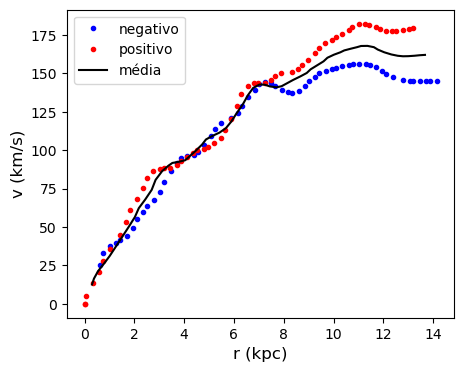

In [96]:

Comp = int(len(ylinha1_S)/2)
x_vStar1 = np.zeros(Comp)
y_vStar1 = np.zeros(Comp)
x_vStar2 = np.zeros(Comp)
y_vStar2 = np.zeros(Comp)

for i in range(Comp):
    if ylinha1_S[i] <= 0:
        y_vStar1[i] = abs(ylinha1_S[i])
        x_vStar1[i] = lVal - l1_S[i] 
    if ylinha1_S[Comp + i] >= 0:
        y_vStar2[i] = ylinha1_S[Comp + i]
        x_vStar2[i] = l1_S[Comp + i] - lVal 

x_vStarMed = np.zeros(Comp)
y_vStarMed = np.zeros(Comp)
for i in range(Comp):
    y_vStarMed[i] = (y_vStar1[i] + y_vStar2[-i-1])/2
    x_vStarMed[i] = (x_vStar1[i] + x_vStar2[-i-1])/2

plt.figure(figsize=(5,4))
plt.plot(arcsec2pc(x_vStar1),  y_vStar1,".",label="negativo", color="blue")
plt.plot(arcsec2pc(x_vStar2),  y_vStar2,".",label="positivo", color="red")
plt.plot(arcsec2pc(x_vStarMed),y_vStarMed,color="k",label="média")
plt.legend()
plt.xlabel("r (kpc)",fontsize=12)
plt.ylabel("v (km/s)",fontsize=12)
plt.savefig("v(r) estrelas.png")
plt.show()

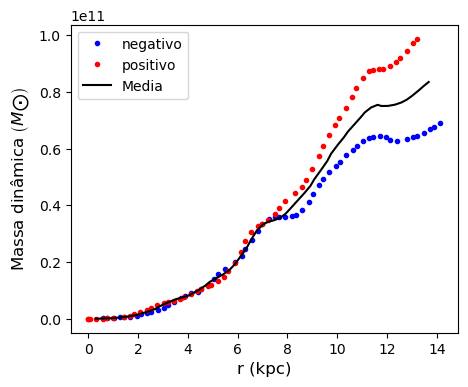

In [97]:
G = 6.674184 * 10 ** -11
ua = 1.495978707 * 10 ** 11         # m
pc = 206264.8 * ua                  # m
mSol = 1.988475 * 10 ** 30          # kg

Mdina1 = np.zeros(Comp)
Mdina2 = np.zeros(Comp)
MdinaMed = np.zeros(Comp)
for i in range(Comp):  
    # Passar para SI
    Mdina1[i]   = (y_vStar1[i]*10**3 )**2   * arcsec2pc(x_vStar1[i])*10**3   * pc / G
    Mdina2[i]   = (y_vStar2[i]*10**3 )**2   * arcsec2pc(x_vStar2[i])*10**3   * pc / G
    MdinaMed[i] = (y_vStarMed[i]*10**3 )**2 * arcsec2pc(x_vStarMed[i])*10**3 * pc / G

plt.figure(figsize=(5,4))
plt.plot(arcsec2pc(x_vStar1),  Mdina1/mSol,".",label="negativo",color="blue")
plt.plot(arcsec2pc(x_vStar2),  Mdina2/mSol,".",label="positivo",color="red")
plt.plot(arcsec2pc(x_vStarMed),MdinaMed/mSol,color="k",label="Media")
plt.legend()
plt.xlabel("r (kpc)",fontsize = 12)
plt.ylabel(r"Massa dinâmica $\left(M_\bigodot\right)$",fontsize = 12)
plt.savefig("M estrelas.png")
plt.show()

In [98]:
# Nomes = ['L1 - continuum between 6390 and 6490'                              
# ,'L2 - segmentation map'                                                    
# ,'L3 - A_V* (mag)'                                                          
# ,'L4 - Ha/Hb   '                                                            
# ,'L5 - sigma Ha/Hb'                                                         
# ,'L6 - V* (km/s)'                                                           
# ,'L7 - sigma* (km/s)'                                                       
# ,'L8 - L-weighted stellar age (Gyr)'                                        
# ,'L9 - sigma L-weighted stellar age (Gyr)'                                  
# ,'L10 - M-weighted stellar age (Gyr)'                                        
# ,'L11 - sigma M-weighted stellar age (Gyr)'                                  
# ,'L12 - L-weighted stellar metallicity (Zsolar)'                             
# ,'L13 - sigma L-weighted stellar metallicity (Zs'                            
# ,'L14 - M-weighted stellar metallicity (Zsolar)'                             
# ,'L15 - sigma M-weighted stellar metallicity (Zs'                            
# ,'L16 - [OIII]5007/Hb'                                                       
# ,'L17 - sigma [OIII]5007/Hb'                                                 
# ,'L18 - [NII]6584/Ha'                                                        
# ,'L19 - sigma [NII]6584/Ha'                                                  
# ,'L20 - [SII]/Ha'                                                            
# ,'L21 - sigma [SII]/Ha'                                                      
# ,'L22 - [OI]/Ha '                                                            
# ,'L23 - sigma [OI]/Ha'                                                       
# ,'L24 - ADEV    '                                                            
# ,'L25 - chi^2/Neff'                                                          
# ,'L26 - S/N [4140:4240]   '                                                  
# ,'L27 - S/N [6390:6490]   '                                                  
# ,'L28 - log10(M* ever formed)'                                               
# ,'L29 - log10(M* current)'                                                   
# ,'L30 - [OII]3727,29 '                                          
# ,'L31 - [OII]3727,29 uncertainty'
# ,'L32 - Hd'                                          
# ,'L33 - Hd uncertainty'          
# ,'L34 - Hg'                                          
# ,'L35 - Hg uncertainty'          
# ,'L36 - [OIII]4363'                                           
# ,'L37 - [OIII]4363 uncertainty'  
# ,'L38 - HeII 4686'                                          
# ,'L39 - HeII 4686 uncertainty'   
# ,'L40 - Hb'                                          
# ,'L41 - Hb uncertainty'          
# ,'L42 - [OIII]4959'                                            
# ,'L43 - [OIII]4959 uncertainty'  
# ,'L44 - [OIII]5007'                                           
# ,'L45 - [OIII]5007 uncertainty'  
# ,'L46 - [OI]6300'                                           
# ,'L47 - [OI]6300 uncertainty'    
# ,'L48 - [NII]6548'                                           
# ,'L49 - [NII]6548 uncertainty'   
# ,'L50 - Ha'                                          
# ,'L51 - Ha + uncertainty'
# ,"L52 - ???"
# ,"L53 - ???"
# ,'L54 - [NII]6584'                                             
# ,'L55 - [NII]6584 uncertainty'
# ,'L56 - [SII]6717'                                             
# ,'L57 - [SII]6717 uncertainty'
# ,'L58 - [SII]6730'                                             
# ,'L59 - [SII]6730 uncertainty'
# ,'L60 - [OII]7319'                                             
# ,'L61 - [OII]7319 uncertainty'
# ,'L62 - [OII]7330'                                             
# ,'L63 - [OII]7330 uncertainty'
# ,'L64 - sum of strongest emission lines'                                     
# ,'L65 - median of L64'
# ,"L66 - ???"
# ,"L67 - ???"
# ,"L68 - ???"
# ,"L69 - ???"
# ,'L70 - vHa (km/s)'                                                          
# ,'L71 - v[NII]6584 (km/s)'                                                   
# ,'L72 - mean v of strongest lines']


# for i in range(72):
#     algo = masking(data[i,:,:],0,10**6)

#     plt.subplots(figsize=(15,6))
#     plt.subplot(1,2,1)
#     norma = simple_norm(algo)
#     im = plt.imshow(algo, origin='lower', norm=norma, cmap=plt.get_cmap("RdBu"), extent=[x0,xf,y0,yf])
#     plt.colorbar(im);
#     plt.contour(smoothConti, norm=normC, levels=contourVals,origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
#     plt.title("{}".format(Nomes[i]))
#     plt.xlabel("arcsec")
#     plt.ylabel("arcsec")
    
#     plt.subplot(1,2,2)
#     norma = simple_norm(algo, "log")
#     im = plt.imshow(algo, origin='lower', norm=norma, cmap=plt.get_cmap("RdBu"), extent=[x0,xf,y0,yf])
#     plt.colorbar(im);
#     plt.contour(smoothConti, norm=normC, levels=contourVals,origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
#     plt.title("{} - logscale".format(Nomes[i]))
#     plt.xlabel("arcsec")
#     plt.ylabel("arcsec")
    
#     plt.show()